*This assignment was done by group of ID*

<YOUR_GROUP_ID> e.g. 10

<YOUR_GROUP_DAY> Tuesday or Wednesday

This assignment is based on the Tensor class. Your task is to train the MLP to perform classification on Fashion MNIST dataset. Your task is to perform hyperparameter search to look for the best hyperparameters for this specific task.

*Important* - Rembmer that you should not use test set to fine-tune your parameters. 

In this assignment, you should apply both Grid Search and Random Search to illustrate the differences in their results. To ensure a fair comparison, the total number of model evaluations should be equal for both Grid Search and Random Search. 
Be sure to present your findings for both scenarios: using a simple train-validation split and employing cross-validation.
Additionally, you are encouraged to experiment with any other hyperparameter optimization techniques you are familiar with. 

Try to find the best hyperparameters in space of:

(1) Batch Size

(2) Learning Rate

(3) Number of Epochs

(4) Activation Functions (here you need to modify MLP Class)

(5) Architectures (Different number of layers, different number of neurons per layer)

Imports

In [1]:
from itertools import product
from typing import List
from Tensor import Tensor

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

MLP Class - here add possibility for using ReLU as a activation function.

In [2]:
class MLP:
    def __init__(self, n_in: int, n_out: int, hidden_dims: list):
        sizes = [n_in] + hidden_dims + [n_out]
        self.layers = []

        for i in range(len(sizes)-1):
            layer = Tensor(shape=(sizes[i+1], sizes[i]), label=f'layer {i}')
            layer.data = np.random.uniform(low=-0.05, high=0.05, size=(sizes[i+1], sizes[i]))
            self.layers.append(layer)

    def __call__(self, x, activation = 'tanh'):
        for idx, layer in enumerate(self.layers):
            x = layer @ x
            if idx < len(self.layers) - 1:
                if activation == 'tanh':
                    x = x.tanh()
                elif activation == 'relu':
                    x = x.relu()
        return x

    def parameters(self):
        return self.layers

MNIST_Net class

In [3]:
class MNIST_Net:
    def __init__(self, hidden_dims=[64]):
        self.mlp = MLP(n_in=784, n_out=10, hidden_dims=hidden_dims)
    def __call__(self, x):
        return self.mlp(x).softmax()
    def parameters(self):
        return self.mlp.parameters()

model = MNIST_Net()

Validate auxilary function

In [4]:
def validate(model, X_set, Y_set):
    """
    Evaluate the accuracy of the model on a given dataset.

    This function performs a forward pass on each sample in the dataset,
    predicts the class, and compares it to the true class to calculate
    the overall accuracy.
    """
    correct_predictions = 0
    total_predictions = 0

    for i in range(X_set.shape[0]):
        x = X_set[i]
        y_true = Y_set[i]

        # Forward pass
        y_pred = model(x)

        # Get the predicted class (assuming y_pred is a Tensor with probabilities)
        predicted_class = np.argmax(y_pred.data)

        # Check if the prediction is correct
        if predicted_class == y_true:
            correct_predictions += 1

        total_predictions += 1

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions
    return accuracy

Fashion MNIST Loading

In [5]:
# Load Fashion MNIST
fashion_mnist = fetch_openml('Fashion-MNIST', version=1)
images, labels = fashion_mnist.data, fashion_mnist.target

images = images.values.reshape(-1, 28, 28)
labels = labels.values
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=60000, test_size=10000, stratify=labels, random_state=42)
print(X_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


Let's see how the datapoints look like

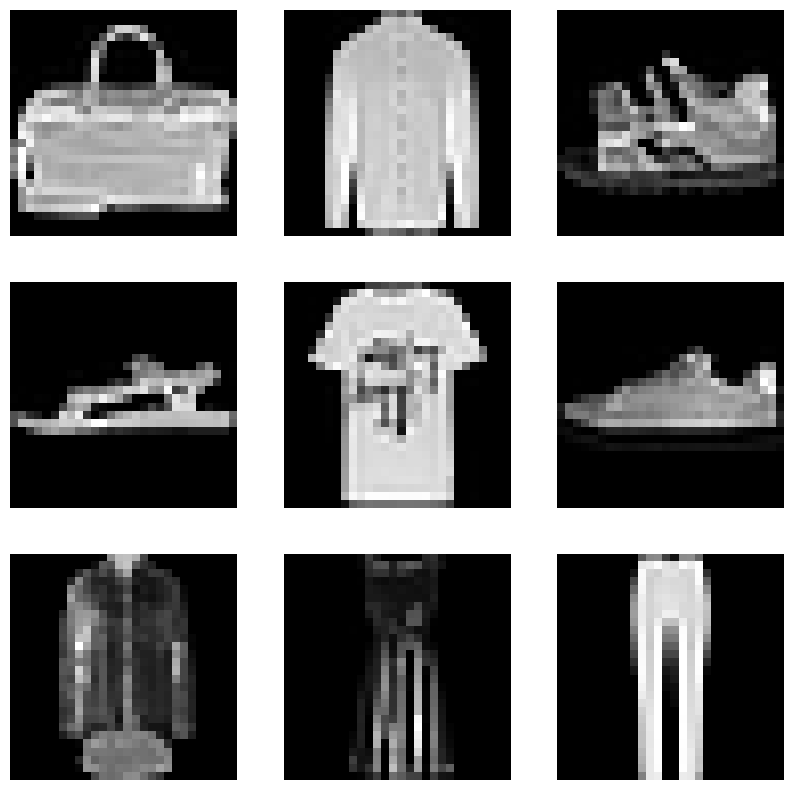

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
    ax = axs[i//3, i%3]
    ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

In [7]:
# Normalize the input data:
X_train = X_train.astype('float32').reshape(-1, 784)
X_test = X_test.astype('float32').reshape(-1, 784)
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')
X_train /= 255.0
X_test /= 255.0

**TRAIN-VAL-TEST**

 In this section, we will search for hyperparameters by splitting the data into a training set (50,000 samples) and a validation set (10,000 samples). We will conduct the hyperparameter search using both Grid Search and Random Search methods.

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=5000, test_size=1000, random_state=42)

Auxilary function to estimate the model

In [9]:
def train_and_evaluate(batch_size:int=32, num_epochs:int=50, lr:float=0.001,
                       hidden_dims:List[int]=[64], test_evaluation:bool=False):
    """
    Train a neural network model and evaluate its performance on a validation set.

    This function trains the `MNIST_Net` model using the given hyperparameters, including
    batch size, number of epochs, learning rate, and hidden layer dimensions. It shuffles
    the training data at the start of each epoch and performs a forward and backward pass
    to update the model weights. The function then evaluates the model on a validation set
    and optionally on a test set.
    """
    model = MNIST_Net(hidden_dims)

    # Training loop
    for epoch in range(num_epochs):
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]

        for i in range(0, X_shuffled.shape[0], batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            # Convert entire batch to flattened Tensors
            X_tensors = [Tensor(data=x.flatten()) for x in X_batch]
            preds = [model(x) for x in X_tensors]

            # Compute loss for the batch
            mb_loss = sum([ypred.cross_entropy(ytrue) for ytrue, ypred in zip(y_batch, preds)]) / batch_size

            # Zero gradients
            for p in model.parameters():
                p.grad = np.zeros_like(p.grad)

            # Backward pass
            mb_loss.backward()

            # Update weights
            for p in model.parameters():
                p.data -= lr * p.grad

    # Calculate validation accuracy
    validation_accuracy = validate(model, X_val, y_val)

    # Calculate test set accuracy
    if test_evaluation:
        test_accuracy = validate(model, X_test, y_test)
        return validation_accuracy, test_accuracy
    else:
        return validation_accuracy

Let's see the exemplary trainig...

In [10]:
model = MNIST_Net()

val_acc = validate(model, X_test, y_test)
print(f"Before training: test accuracy: {val_acc}")

# Parameters
batch_size = 64
num_epochs = 1
lr = 0.5

val_acc = train_and_evaluate(batch_size, num_epochs, lr)
print(f"Validation accuracy: {val_acc}")


Before training: test accuracy: 0.1223
Validation accuracy: 0.714


*GRID SEARCH*

In [11]:
# Add here more possibilities
hyperparameter_space = {
    'batch_size': [256, 128],
    'num_epochs': [10],
    'lr': [0.01, 0.1, 0.001],
    'hidden_dims': [[64], [128, 64], [64, 64, 64]]
}


all_combinations_grid_search = list(product(
    hyperparameter_space['batch_size'],
    hyperparameter_space['num_epochs'],
    hyperparameter_space['lr'],
    hyperparameter_space['hidden_dims']
))

In [12]:
len(all_combinations_grid_search)

18

In [13]:
import time

best_accuracy = 0
for batch_size, num_epochs, lr, hidden_size in all_combinations_grid_search:
    print(f"Training with batch size: {batch_size}, num epochs: {num_epochs}, lr: {lr}, hidden size: {hidden_size}")
    start = time.time()
    accuracy = train_and_evaluate(batch_size, num_epochs, lr, hidden_size)
    print(f"Validation accuracy: {accuracy}, time taken: {round(time.time() - start)} seconds")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparameters = (batch_size, num_epochs, lr, hidden_size)

Training with batch size: 256, num epochs: 10, lr: 0.01, hidden size: [64]
Validation accuracy: 0.525, time taken: 13 seconds
Training with batch size: 256, num epochs: 10, lr: 0.01, hidden size: [128, 64]
Validation accuracy: 0.452, time taken: 21 seconds
Training with batch size: 256, num epochs: 10, lr: 0.01, hidden size: [64, 64, 64]
Validation accuracy: 0.132, time taken: 18 seconds
Training with batch size: 256, num epochs: 10, lr: 0.1, hidden size: [64]
Validation accuracy: 0.747, time taken: 13 seconds
Training with batch size: 256, num epochs: 10, lr: 0.1, hidden size: [128, 64]
Validation accuracy: 0.678, time taken: 21 seconds
Training with batch size: 256, num epochs: 10, lr: 0.1, hidden size: [64, 64, 64]
Validation accuracy: 0.43, time taken: 18 seconds
Training with batch size: 256, num epochs: 10, lr: 0.001, hidden size: [64]
Validation accuracy: 0.366, time taken: 13 seconds
Training with batch size: 256, num epochs: 10, lr: 0.001, hidden size: [128, 64]
Validation acc

After finding the best hyperparameters we evaluate them on test set

In [15]:
best_batch_size, best_num_epochs, best_lr, best_hidden_size = best_hyperparameters
grid_search_train_val_validation, grid_search_train_val_test = train_and_evaluate(best_batch_size, best_num_epochs, best_lr, best_hidden_size, True)
print(f"Final Validation Accuracy: {round(grid_search_train_val_validation, 3)}")
print(f"Final Test Accuracy: {round(grid_search_train_val_test, 3)}")

Final Validation Accuracy: 0.799
Final Test Accuracy: 0.794


In [16]:
print(best_batch_size, best_num_epochs, best_lr, best_hidden_size)

128 10 0.1 [64]


**TRAIN VAL TEST - Random Search**

In [ ]:
# Expand the hyperparameter space with additional options if needed.
# Implement a similar approach for random search, where hyperparameters are sampled randomly.
# Note: The hyperparameter space for random search can be larger compared to grid search,
# as you are not limited to predefined discrete values.
# However, to ensure a fair comparison between grid search and random search,
# make sure to evaluate the model the same number of times in both methods.
hyperparameter_space_random_search = {
    'batch_size': [256, 128, 64, 32],
    'num_epochs': [1, 5, 10, 15, 20],
    'lr': [0.5, 0.1, 0.01, 0.001],
    'hidden_dims': [[64], [128, 64], [64, 64, 64]]
}

all_combinations_random_search = list(product(
    hyperparameter_space_random_search['batch_size'],
    hyperparameter_space_random_search['num_epochs'],
    hyperparameter_space_random_search['lr'],
    hyperparameter_space_random_search['hidden_dims']
))

def sample(hyperparameter_space):
    ind = np.random.randint(0, len(all_combinations_random_search), 1)[0]
    return all_combinations_random_search.pop(ind)


best_accuracy = 0
for _ in range(len(all_combinations_grid_search)):
    sampled_hyperparameters = sample(hyperparameter_space_random_search)
    batch_size, num_epochs, lr, hidden_size = sampled_hyperparameters
    print(f"Training with batch size: {batch_size}, num epochs: {num_epochs}, lr: {lr}, hidden size: {hidden_size}")
    start = time.time()
    accuracy = train_and_evaluate(batch_size, num_epochs, lr, hidden_size)
    print(f"Validation accuracy: {accuracy}, time taken: {round(time.time() - start, 2)} seconds")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparameters = (batch_size, num_epochs, lr, hidden_size)

Training with batch size: 256, num epochs: 10, lr: 0.5, hidden size: [64, 64, 64]
Validation accuracy: 0.688, time taken: 18.45 seconds
Training with batch size: 64, num epochs: 1, lr: 0.1, hidden size: [64]
Validation accuracy: 0.652, time taken: 1.32 seconds
Training with batch size: 128, num epochs: 10, lr: 0.1, hidden size: [64, 64, 64]
Validation accuracy: 0.627, time taken: 18.03 seconds
Training with batch size: 256, num epochs: 5, lr: 0.5, hidden size: [64, 64, 64]
Validation accuracy: 0.587, time taken: 9.2 seconds
Training with batch size: 32, num epochs: 10, lr: 0.001, hidden size: [128, 64]
Validation accuracy: 0.454, time taken: 19.65 seconds
Training with batch size: 128, num epochs: 10, lr: 0.01, hidden size: [128, 64]
Validation accuracy: 0.54, time taken: 20.55 seconds
Training with batch size: 128, num epochs: 15, lr: 0.01, hidden size: [128, 64]
Validation accuracy: 0.512, time taken: 30.65 seconds
Training with batch size: 128, num epochs: 5, lr: 0.01, hidden size: 

After finding the best hyperparameters with random search we evalute them

In [ ]:
best_batch_size, best_num_epochs, best_lr, best_hidden_size = best_hyperparameters
random_search_train_val_validation, random_search_train_val_test = train_and_evaluate(best_batch_size, best_num_epochs, best_lr, best_hidden_size, True)
print(f"Final Validation Accuracy: {round(grid_search_train_val_validation, 3)}")
print(f"Final Test Accuracy: {round(random_search_train_val_test, 3)}")

Final Validation Accuracy: 0.776
Final Test Accuracy: 0.837


In [ ]:
print(best_batch_size, best_num_epochs, best_lr, best_hidden_size)

64 20 0.1 [64]


**Cross-Validation**

In this section, we will perform hyperparameter tuning using cross-validation. We will explore both Grid Search and Random Search methods. To ensure a fair comparison, make sure to evaluate your model the same number of times as in previous searches. Keep in mind that cross-validation involves training and evaluating the model multiple times for each set of hyperparameters, which provides a more robust estimate of model performance.

Let's load data once more

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=6000, test_size=1000, stratify=labels, random_state=42)

Auxilary function for model estimation with cross validation

In [64]:
folds = 5
first_k_folds = len(indices) % folds
number_of_samples = len(indices) // folds

indices1 = np.arange(0, first_k_folds*(number_of_samples + 1), number_of_samples + 1)
indices2 = np.arange((first_k_folds)*(number_of_samples + 1), len(indices), number_of_samples)
print(indices1, indices2)
print(np.diff(np.append(indices1, indices2)))

for ar in np.split(indices, np.append(indices1, indices2))[1:]:
    print(ar.shape)

[] [   0 1000 2000 3000 4000]
[1000 1000 1000 1000]
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


In [70]:
# Complete this function.

def train_and_evaluate_cv(batch_size: int = 32, num_epochs: int = 50, lr: float = 0.001,
                       hidden_dims: List[int] = [64], folds: int = 5, test_evaluation: bool = False):

    # Initialize K-Fold cross-validation
    validation_accuracies = []

    def split_data_into_folds(folds):
        kf = []
        indices = np.arange(X_train.shape[0])
        first_k_folds = len(indices) % folds
        number_of_samples = len(indices) // folds

        # split the indices into folds
        # first k folds will have one more sample
        # the rest will have the same number of samples
        indices1 = np.arange(0, first_k_folds*(number_of_samples + 1), number_of_samples + 1)
        indices2 = np.arange((first_k_folds)*(number_of_samples + 1), len(indices), number_of_samples)

        # the first index of the appended array is 0, so we need to remove it
        indices = np.split(indices, np.append(indices1, indices2))[1:]

        for k in range(len(indices)):
            kf.append([np.concatenate(indices[:k] + indices[k+1:]), indices[k]])

        return kf

    kf = split_data_into_folds(folds) # funciton that generates indicies of belonging to specific fold

    # Cross-validation loop
    for train_index, val_index in kf:
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

        # Initialize the model for each fold
        model = MNIST_Net(hidden_dims)

        # Training loop
        for epoch in range(num_epochs):
            indices = np.arange(X_fold_train.shape[0])
            np.random.shuffle(indices)
            X_shuffled = X_fold_train[indices]
            y_shuffled = y_fold_train[indices]

            for i in range(0, X_shuffled.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]

                # Convert entire batch to flattened Tensors
                X_tensors = [Tensor(data=x.flatten()) for x in X_batch]
                preds = [model(x) for x in X_tensors]

                # Compute loss for the batch
                mb_loss = sum([ypred.cross_entropy(ytrue) for ytrue, ypred in zip(y_batch, preds)]) / batch_size

                # Zero gradients
                for p in model.parameters():
                    p.grad = np.zeros_like(p.grad)

                # Backward pass
                mb_loss.backward()

                # Update weights
                for p in model.parameters():
                    p.data -= lr * p.grad

        # Calculate validation accuracy for this fold
        validation_accuracy = validate(model, X_fold_val, y_fold_val)
        validation_accuracies.append(validation_accuracy)

    # Compute the average validation accuracy across all folds
    avg_validation_accuracy = np.mean(validation_accuracies)

    # Calculate test set accuracy if required
    if test_evaluation:
        test_accuracy = validate(model, X_test, y_test)
        return avg_validation_accuracy, test_accuracy
    else:
        return avg_validation_accuracy

Grid Search

In [71]:
# Define the hyperparameter search space. Note: it should be smaller than the one used in the train-val-test example.
# To ensure a fair comparison, each technique should evaluate the exact same number of models.
hyperparameter_space = {
    'batch_size': [256, 128],
    'num_epochs': [10],
    'lr': [0.1, 0.01],
    'hidden_dims': [[64], [128, 64]]
}

all_combinations_grid_search_cv = list(product(
    hyperparameter_space['batch_size'],
    hyperparameter_space['num_epochs'],
    hyperparameter_space['lr'],
    hyperparameter_space['hidden_dims']
))

best_accuracy = 0
folds = 5
for batch_size, num_epochs, lr, hidden_size in all_combinations_grid_search:
    accuracy = train_and_evaluate_cv(batch_size, num_epochs, lr, hidden_size, folds)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparameters = (batch_size, num_epochs, lr, hidden_size)

After identifying the optimal hyperparameters through a grid search with cross-validation, we evaluate their performance on the test set

In [73]:
best_hyperparameters

(128, 10, 0.1, [64])

In [74]:
def estimate_model_and_evaluate(hyperparameters, test_evaluation=False):
    batch_size, num_epochs, lr, hidden_size = hyperparameters
    return train_and_evaluate_cv(batch_size, num_epochs, lr, hidden_size, folds, test_evaluation)

In [75]:
best_batch_size, best_num_epochs, best_lr, best_hidden_size = best_hyperparameters
grid_search_cv_validation, grid_search_cv_test = estimate_model_and_evaluate(best_hyperparameters, test_evaluation=True)
print(f"Final Validation Accuracy: {round(grid_search_cv_validation, 3)}")
print(f"Final Test Accuracy: {round(grid_search_cv_test, 3)}")

Final Validation Accuracy: 0.793
Final Test Accuracy: 0.788


Random Search

In [78]:
# Hyperparameter search space. Remember that it should be smaller than one used in the train-val-test example.
# For a fair comparison we should estimate by each technique exactly the same number of models.
hyperparameter_space_random_search = {
    'batch_size': [128, 256, 512],
    'num_epochs': [1, 5, 10],
    'lr': [0.1, 0.01, 0.001],
    'hidden_dims': [[64], [128, 64], [64, 64, 64]]
}

all_combinations_random_search_cv = list(product(
    hyperparameter_space_random_search['batch_size'],
    hyperparameter_space_random_search['num_epochs'],
    hyperparameter_space_random_search['lr'],
    hyperparameter_space_random_search['hidden_dims']
))

def sample(hyperparameter_space):
    ind = np.random.randint(0, len(all_combinations_random_search_cv), 1)[0]
    return all_combinations_random_search_cv.pop(ind)

best_accuracy = 0
for _ in range(len(all_combinations_grid_search)):
    sampled_hyperparameters = sample(hyperparameter_space_random_search)
    batch_size, num_epochs, lr, hidden_size = sampled_hyperparameters
    accuracy = train_and_evaluate_cv(batch_size, num_epochs, lr, hidden_size)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparameters = (batch_size, num_epochs, lr, hidden_size)

After identifying the optimal hyperparameters through a random search with cross-validation, we evaluate their performance on the test set.

In [79]:
best_batch_size, best_num_epochs, best_lr, best_hidden_size = best_hyperparameters
random_search_cv_validation, random_search_cv_test = estimate_model_and_evaluate(best_hyperparameters, test_evaluation=True)
print(f"Final Validation Accuracy: {round(random_search_cv_validation, 3)}")
print(f"Final Test Accuracy: {round(random_search_cv_test, 3)}")

Final Validation Accuracy: 0.783
Final Test Accuracy: 0.762


Another hyperparameter optimization technique (Optional)

In [80]:
optional_test = 0.89
print(f"Final Test Accuracy: {round(optional_test, 3)}")

Final Test Accuracy: 0.89


Summary of all our results:

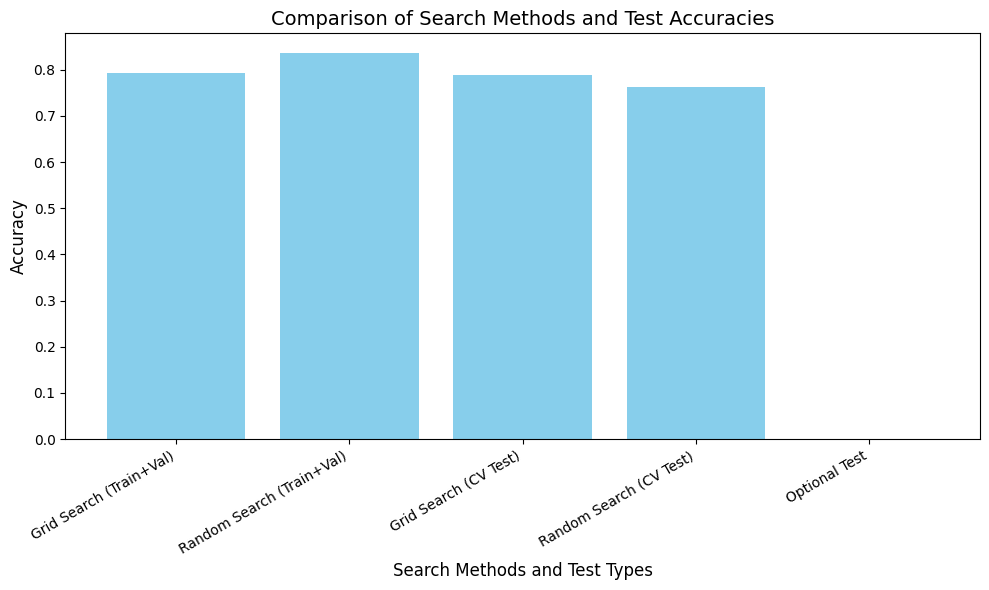

In [83]:
grid_search_train_val_test = 0.794
random_search_train_val_test = 0.837
grid_search_cv_test = 0.788
random_search_cv_test = 0.762
optional_test = 0.00


# Data for the bar plot
labels = ['Grid Search (Train+Val)', 'Random Search (Train+Val)',
          'Grid Search (CV Test)', 'Random Search (CV Test)', 'Optional Test']
values = [
        grid_search_train_val_test,
          random_search_train_val_test,
          grid_search_cv_test,
          random_search_cv_test,
          optional_test
          ]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Search Methods and Test Types', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of Search Methods and Test Accuracies', fontsize=14)
plt.xticks(rotation=30, ha='right', fontsize=10)
plt.tight_layout()
plt.show()
